<h1> Task 1 </h1>
<h3> 2. Load the three JSON files and encode them as pandas dataframes. </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
training_url = '/content/drive/MyDrive/Assignment 1/data/training.json'
validation_url = '/content/drive/MyDrive/Assignment 1/data/validation.json'
test_url = '/content/drive/MyDrive/Assignment 1/data/test.json'

In [4]:
training_set = pd.read_json(training_url, orient='index')
validation_set = pd.read_json(validation_url, orient='index')
test_set = pd.read_json(test_url, orient='index')

<h3> 3. Generate hard labels for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. <br>Items without a clear majority will be removed from the dataset. </h3>

In [5]:
def majority(l):
    y_count = l.count('YES')
    n_count = l.count('NO')

    if y_count == n_count:
        return pd.NaT

    if y_count > 3:
        return 'YES'

    return 'NO'

In [6]:
training_set['hard_label_task1'] = training_set['labels_task1'].apply(majority)
training_set.dropna(axis=0, inplace=True)

validation_set['hard_label_task1'] = validation_set['labels_task1'].apply(majority)
validation_set.dropna(axis=0, inplace=True)

test_set['hard_label_task1'] = test_set['labels_task1'].apply(majority)
test_set.dropna(axis=0, inplace=True)

<h3> 4. Filter the DataFrame to keep only rows where the `lang` column is `'en'`. </h3>

In [7]:
lang = 'en'

In [8]:
training_set = training_set[training_set['lang'] == lang]
validation_set = validation_set[validation_set['lang'] == lang]
test_set = test_set[test_set['lang'] == lang]

<h3> 5. Remove unwanted columns: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`. </h3>

In [9]:
training_set = training_set.loc[:,['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
validation_set = validation_set.loc[:,['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
test_set = test_set.loc[:,['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

<h3> 6. Encode the `hard_label_task1` column: Use 1 to represent "YES" and 0 to represent "NO".</h3>

In [10]:
training_set['hard_label_task1'] = training_set['hard_label_task1'].map({'YES':1, 'NO':0})
validation_set['hard_label_task1'] = validation_set['hard_label_task1'].map({'YES':1, 'NO':0})
test_set['hard_label_task1'] = test_set['hard_label_task1'].map({'YES':1, 'NO':0})

In [11]:
training_set

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0
...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,1
203257,203257,en,This has been a part of an experiment with @Wo...,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",1
203259,203259,en,@clintneedcoffee why do you look like a whore?...,1


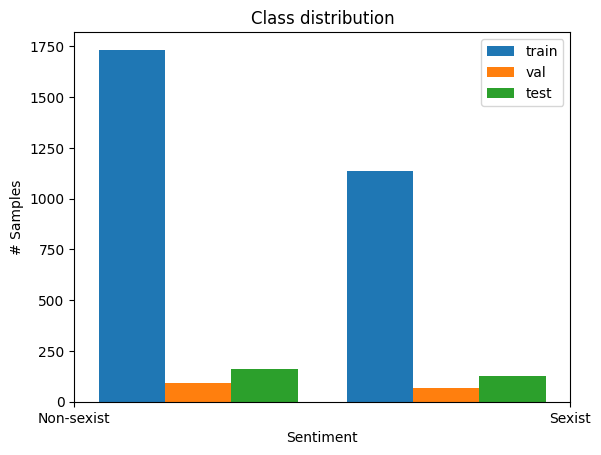

In [105]:
#@title inspect positive/negative distribution
train_labels = training_set['hard_label_task1'].values
val_labels = validation_set['hard_label_task1'].values
test_labels = test_set['hard_label_task1'].values

plt.hist([train_labels, val_labels, test_labels], bins = 2, label = ['train', 'val', 'test'])
plt.legend()
plt.title('Class distribution')
plt.xlabel('Sentiment')
plt.ylabel('# Samples')
plt.xticks([0, 1], ['Non-sexist', 'Sexist'])  # Set the x-axis ticks
plt.show()

Training set size: 2870
Validation set size: 158
Test set size: 286


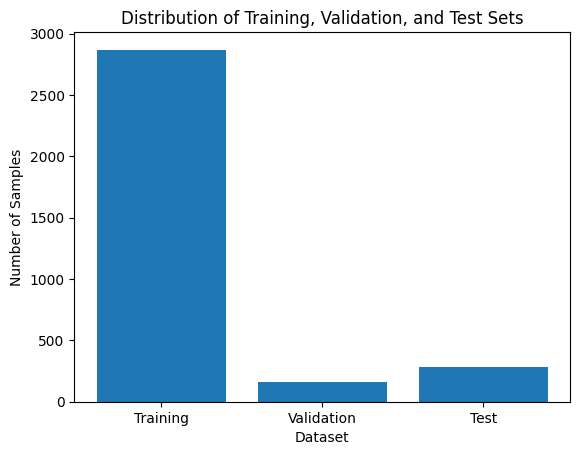

In [106]:
#@title inspect training/val/test distribution
train_counts = training_set.shape[0]
val_counts = validation_set.shape[0]
test_counts = test_set.shape[0]

print(f'Training set size: {train_counts}')
print(f'Validation set size: {val_counts}')
print(f'Test set size: {test_counts}')

# Data for histogram
data = [train_counts, val_counts, test_counts]
labels = ['Training', 'Validation', 'Test']

# Create a histogram
plt.bar(labels, data)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Distribution of Training, Validation, and Test Sets')

# Show the plot
plt.show()

<h1> Task 2 </h1>

- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [14]:
!pip install emoji

import re
import emoji
from nltk.corpus import stopwords
import nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 14.4 MB/s eta 0:00:00


In [15]:
emojis_list = map(lambda x: ''.join(x.split()), emoji.EMOJI_DATA.keys())

EMOJI_RE = re.compile('|'.join(re.escape(p) for p in emojis_list))
HASHTAGS_RE = re.compile('#\w+')
MENTIONS_RE = re.compile('@\w+')
URL_RE = re.compile('(https|http)?:\/\/\S+')
#Qui ho aggiunto il punto sostituito dallo spazio perchè mi sembra che la maggior parte
#dei tweets ne traggono beneficio, poi TODO va provato raga
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;‘’“”\"\.]')
SPECIAL_CHARACTERS_RE = re.compile('&amp;')
GOOD_SYMBOLS_RE = re.compile('[^\w+ +]')

try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
def lower(text: str) -> str:
    return text.lower()

def remove_emojis(text: str) -> str:
    return EMOJI_RE.sub(' ',text)

def remove_hashtags(text: str) -> str:
    return HASHTAGS_RE.sub(' ', text)

def remove_mentions(text: str) -> str:
    return MENTIONS_RE.sub(' ', text)

def remove_url(text: str) -> str:
    return URL_RE.sub(' ',text)

def remove_special_characters(text: str) -> str:
    return SPECIAL_CHARACTERS_RE.sub('', text)

def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the good symbols list (check regular expression)
    """
    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

We can observe that some hashtags in the form "#somethinghttps://" also removes the initial part of the link.

@rufinelix's account

In [17]:
from typing import List, Callable, Dict
from functools import reduce

PREPROCESSING_PIPELINE = [
                          lower,
                          remove_emojis,
                          remove_hashtags,
                          remove_mentions,
                          remove_url,
                          remove_special_characters,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text
                          ]
#Lui elimina anche le stopwords, poi TODO va provato raga

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [18]:
print('Pre-processing text...')

print()
print(f'[Debug] Before:\n{training_set.tweet.values[2]}')
print()

# Replace each sentence with its pre-processed version
training_set['tweet'] = training_set['tweet'].apply(lambda txt: text_prepare(txt))
validation_set['tweet'] = validation_set['tweet'].apply(lambda txt: text_prepare(txt))
test_set['tweet'] = test_set['tweet'].apply(lambda txt: text_prepare(txt))

print(f'[Debug] After:\n{training_set.tweet.values[2]}')
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
According to a customer I have plenty of time to go spent the Stirling coins he wants to pay me with, in Derry. "Just like any other woman, I'm sure of it." #EveryDaySexism in retail.

[Debug] After:
according customer plenty time go spent stirling coins wants pay derry like woman im sure retail

Pre-processing completed!


In [19]:
#Focus Focus Focus qui le contrazioni tipo I'm le accorpa, ma sotto la lemmatization con wordNet le
#scoppia. Se usassimo le stopwords le eliminerebbe direttamente e il problema non si porrebbe, quindi indovinate
#TODO va provato raga
training_set.iloc[:10]['tweet']

,tweet
200002,writing uni essay local pub coffee random old ...
200003,2021 1921 dont appreciate two rides team membe...
200006,according customer plenty time go spent stirli...
200007,blokes drink beer sorry arent bloke drink wine...
200008,new shelves week looking forward reading books
200010,guess fairly normal neanderthal
200011,means women usually end lower paid support wor...
200013,hi orla interesting piece 2 policy response be...
200015,dear god colette capable identifying sexism li...
200016,women home cooking family


In [20]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [21]:
training_set['tweet'][:10]

,tweet
200002,writing uni essay local pub coffee random old ...
200003,2021 1921 dont appreciate two rides team membe...
200006,according customer plenty time go spent stirli...
200007,blokes drink beer sorry arent bloke drink wine...
200008,new shelves week looking forward reading books
200010,guess fairly normal neanderthal
200011,means women usually end lower paid support wor...
200013,hi orla interesting piece 2 policy response be...
200015,dear god colette capable identifying sexism li...
200016,women home cooking family


In [22]:
lem_train_texts = [lem_text(text) for text in training_set['tweet']]
lem_validation_texts = [lem_text(text) for text in validation_set['tweet']]
lem_test_texts = [lem_text(text) for text in test_set['tweet']]

In [23]:
lem_train_texts[:10]

['write uni essay local pub coffee random old man keep ask drunk question im try concentrate end good luck youll end get marry use anyway alive well',
 '2021 1921 dont appreciate two ride team member look behind ask man behind many party impress',
 'accord customer plenty time go spent stirling coin want pay derry like woman im sure retail',
 'bloke drink beer sorry arent bloke drink wine apparently alive well',
 'new shelf week look forward read book',
 'guess fairly normal neanderthal',
 'mean woman usually end low pay support work start change traditionalist notice unfairness previously hasnt bother',
 'hi orla interest piece 2 policy response believe earlyinlife prosecution punishment way go boy young men offend girl woman see zero tolerance approach institute',
 'dear god colette capable identify sexism literally anywhere good see develop female grandpa simpson',
 'woman home cooking family']

In [24]:
training_set['tweet'] = lem_train_texts
validation_set['tweet'] = lem_validation_texts
test_set['tweet'] = lem_test_texts

In [25]:
# Find the longest tweet
longest_tweet = max(training_set['tweet'], key=lambda x: len(x.split()))
longest_tweet_length = len(longest_tweet.split())

print(f"Longest tweet: {longest_tweet}")
print(f"Length of the longest tweet: {longest_tweet_length}")

Longest tweet: movie 103+ haunt tale 1980 + house 1977 + gift hate 2019 + ouijia japan 2021 + dream home 2010 + ghoul 2018 + ringu spiral 1998 + ringu 0 2000 + gaze 2014 + 3 2012 + daughter 2015 + roommate 2010
Length of the longest tweet: 43


<h1> Task 3 </h1>

Embed words using **GloVe embeddings**. <br>
You are **free** to pick any embedding dimension.

In [26]:
from collections import OrderedDict

In [27]:
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0
    for sentence in df.tweet:
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_to_idx['UNK'] = curr_idx
    idx_to_word[curr_idx] = 'UNK'

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [28]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(training_set)
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10) + 1]}')

[Debug] Index -> Word vocabulary size: 9363
[Debug] Word -> Index vocabulary size: 9363
[Debug] Some words: [('uni', 1), ('essay', 2), ('local', 3), ('pub', 4), ('coffee', 5), ('random', 6), ('old', 7), ('man', 8), ('keep', 9), ('ask', 10)]


In [29]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(training_set)

In [30]:
import gensim
import gensim.downloader as gloader

In [31]:
embedding_dimension = 50
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
emb_model = gloader.load(download_path)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [32]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [33]:
oov_terms = check_OOV_terms(emb_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 1340 (14.31%)


In [34]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [35]:
embedding_matrix = build_embedding_matrix(emb_model, embedding_dimension, word_to_idx, len(word_to_idx), oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (9363, 50)


#### Creating an extra column for each dataset to store all the token ids

In [36]:
def preprocess_text(sentence: str, word_to_idx: Dict[str, int]) -> List[int]:
    """
    Maps tokens in a sentence to vocabulary indices, replacing OOV terms with 'UNK'.

    :param sentence: input sentence (str)
    :param word_to_idx: word-to-index mapping (dict)
    :return: list of token indices (list of int)
    """
    tokens = sentence.split()
    return [word_to_idx.get(token, word_to_idx['UNK']) for token in tokens]

training_set['processed'] = training_set['tweet'].apply(
    lambda x: preprocess_text(x, word_to_idx)
)

# Validation/Test: Preprocess to handle OOV terms
validation_set['processed'] = validation_set['tweet'].apply(
    lambda x: preprocess_text(x, word_to_idx)
)
test_set['processed'] = test_set['tweet'].apply(
    lambda x: preprocess_text(x, word_to_idx)
)

# Inspect a test sentence
print("Original:", test_set['tweet'].iloc[0])
print("Processed indices:", test_set['processed'].iloc[0])
print("Embedding for 'UNK':", embedding_matrix[word_to_idx['UNK']])

Original: 1st day pool beautiful sunday ny bad dare go due frigid water temp last 45 min figure prove point
Processed indices: [5076, 299, 9094, 1952, 1176, 2871, 432, 2310, 43, 668, 4916, 4763, 4990, 1055, 9362, 2277, 775, 479, 534]
Embedding for 'UNK': [-0.03423638 -0.04037788  0.03927495  0.01411903 -0.02407469 -0.01292279
  0.04877555  0.02823019 -0.0334676   0.00039937  0.04243974 -0.04994696
 -0.03976547 -0.00955637 -0.01246469  0.00523981 -0.04543075  0.03449975
  0.04644118 -0.02044027 -0.02300485 -0.01329774  0.00892151 -0.03442668
 -0.01121421 -0.03540561  0.02340687  0.03535169 -0.01508977 -0.04947844
  0.00381082  0.03058171  0.01768894 -0.00056706  0.00464986 -0.00975244
  0.01473147  0.04949906  0.00735581 -0.02571322 -0.01677164 -0.02959329
  0.02861297 -0.01857175 -0.04674732 -0.00402999  0.04905752  0.03304094
 -0.03411354 -0.02476538]


In [37]:
training_set['processed']

,processed
200002,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
200003,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 10, 8..."
200006,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5..."
200007,"[54, 55, 56, 57, 58, 54, 55, 59, 60, 24, 25]"
200008,"[61, 62, 63, 34, 64, 65, 66]"
...,...
203256,"[902, 271, 523, 1084, 1708, 1827, 1919, 34, 50..."
203257,"[263, 3537, 13, 990, 1098, 2181, 1362, 6513, 3..."
203258,"[623, 361, 705, 188, 1151, 13, 6401, 370, 6380..."
203259,"[34, 50, 2238, 9360]"


In [38]:
embedding_matrix

array([[-0.065611  ,  0.18878   ,  0.38947   , ...,  0.50332   ,
        -0.37874   ,  0.78717   ],
       [-0.48424   ,  0.10052   , -0.20392   , ...,  0.528     ,
         0.47025   , -0.099937  ],
       [-0.73514   ,  1.0877    , -1.0185    , ...,  0.40231   ,
         0.07081   ,  0.24598   ],
       ...,
       [ 0.94112   ,  0.072009  ,  0.054059  , ..., -1.035     ,
        -0.1885    ,  0.35589   ],
       [ 0.17566   ,  0.40873   , -0.3003    , ..., -0.67123   ,
        -0.91092   ,  0.88043   ],
       [-0.03423638, -0.04037788,  0.03927495, ...,  0.03304094,
        -0.03411354, -0.02476538]], dtype=float32)

## TASK 4

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

In [39]:
from keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score
import tensorflow as tf
from itertools import product

#### Padding sentences to achieve the same length for each of them
TODO: padding dynamically within each batch

In [40]:
max_length = longest_tweet_length  # Define a fixed maximum sequence length
train_padded = pad_sequences(training_set['processed'], maxlen=max_length, padding='post')
validation_padded = pad_sequences(validation_set['processed'], maxlen=max_length, padding='post')
test_padded = pad_sequences(test_set['processed'], maxlen=max_length, padding='post')

In [41]:
train_padded.shape

(2870, 43)

#### Defining embedding layer

In [42]:
vocab_size = len(word_to_idx)

embedding_layer = Embedding(
                            input_dim=vocab_size,
                            output_dim=embedding_dimension,
                            weights=[embedding_matrix],
                            mask_zero=True,                # automatically masks padding tokens
                            name='encoder_embedding'
                            #trainable=False               # default: learnable params
                            )

In [43]:
#@title - working directly with the embeddings

In [44]:
#@title - working with the Embedding Layer
# defining a bidirectional LSTM
def create_model(name, hidden_units=64, activation="sigmoid", extra_LSTM=False):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=extra_LSTM)))

    # add an extra LSTM layer for Model 1
    if extra_LSTM:
      model.add(LSTM(hidden_units, return_sequences=False))

    model.add(Dense(1, activation=activation))
    model.name = name
    return model

## Task 5
Training and evaluating Baseline and Model 1

In [45]:
models = ["baseline", "model_1"]

In [ ]:
def train_model(model, seed, training_data, training_labels, val_data, val_labels, epochs = 10, batch_size = 32):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall']) #binary loss because we have a binary classification task
    history = model.fit(training_data, training_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

    # evaluate the model using the supported metrics
    val_results = model.evaluate(val_data, val_labels, verbose=0)

    val_loss = val_results[0]
    val_accuracy = val_results[1]
    val_precision = val_results[2]
    val_recall = val_results[3]

    # evaluate also using f1-macro
    val_predictions = model.predict(val_data)
    val_predictions = (val_predictions > 0.5).astype(int)  # binarize predictions
    val_f1_macro = f1_score(val_labels, val_predictions, average='macro')

    return history, val_loss, val_accuracy, val_precision, val_recall, val_f1_macro

In [ ]:
# Define seed list and hyperparams
seeds = [39, 42, 777]
hidden_units = 64  # Set specific value for hidden_units
batch_size = 32    # Set specific value for batch_size

# Initialize the results dict. to store results for each model
results = {model_name: [] for model_name in models}

# Loop over each model
for model_name in models:
    print(f"Showing results for the following model: {model_name}")

    # Iterate over different seeds
    for seed in seeds:
        print(f"Seed {seed}")

        # Create the specified model with the current hyperparams
        model = create_model(
            name=model_name,
            hidden_units=hidden_units,
        ) if model_name == "baseline" else create_model(name=model_name, hidden_units=hidden_units, extra_LSTM=True)

        # Train the model and get the results
        history, val_loss, val_accuracy, val_precision, val_recall, val_f1_macro = train_model(
            model=model, seed=seed, training_data=train_padded, training_labels=training_set['hard_label_task1'],
            val_data=validation_padded, val_labels=validation_set['hard_label_task1'], batch_size=batch_size
        )

        # Store the results in the dict
        results[model_name].append({
            "seed": seed,
            "hidden_units": hidden_units,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1_macro": val_f1_macro,
            "history": history
        })

Showing results for the following model: baseline
Seed 39
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.7913 - loss: 0.4243 - precision: 0.7934 - recall: 0.6849 - val_accuracy: 0.7785 - val_loss: 0.7899 - val_precision: 0.7895 - val_recall: 0.6618
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9949 - loss: 0.0326 - precision: 0.9906 - recall: 0.9970 - val_accuracy: 0.7595 - val_loss: 1.0150 - val_precision: 0.7586 - val_recall: 0.6471
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9969 - loss: 0.0129 - precision: 0.9959 - recall: 0.9966 - val_accuracy: 0.7658 - val_loss: 1.1329 - val_precision: 0.7627 - val_recall: 0.6618
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.9969 - loss: 0.0114 - precision: 0.9927 - recall: 1.0000 - val_accuracy: 0.7785 - val_loss: 1.2621 - val_precision: 0.8000 - val_recall: 0.6471
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 1.0000 - loss: 0.0039 - precision: 1.00

In [ ]:
# Flatten the data into a list of dictionaries
data = []
for model_name, model_results in results.items():
    for result in model_results:
        data.append({
            "Model": model_name,
            "Seed": result["seed"],
            "Hidden Units": result["hidden_units"],
            "Val Loss": result["val_loss"],
            "Val Accuracy": result["val_accuracy"],
            "Val Precision": result["val_precision"],
            "Val Recall": result["val_recall"],
            "Val F1 Macro": result["val_f1_macro"],
        })

# Create a DataFrame
df = pd.DataFrame(data)

# Print the table
print(df)

      Model  Seed  Hidden Units  Val Loss  Val Accuracy  Val Precision  \
0  baseline    39            64  1.827943      0.784810       0.814815   
1  baseline    42            64  1.733375      0.778481       0.779661   
2  baseline   777            64  1.798582      0.778481       0.811321   
3   model_1    39            64  1.900424      0.784810       0.814815   
4   model_1    42            64  1.883715      0.784810       0.793103   
5   model_1   777            64  2.171396      0.765823       0.816327   

   Val Recall  Val F1 Macro  
0    0.647059      0.773027  
1    0.676471      0.769612  
2    0.632353      0.765628  
3    0.647059      0.773027  
4    0.676471      0.775606  
5    0.588235      0.748916  


In [ ]:
#@title average results of each model to obtain the best configuration

# Initialize a dictionary to store the averages for each model
averaged_results = {}

# Iterate over each model
for model_name, model_results in results.items():
    # Initialize sums for the metrics
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_precision = 0
    total_val_recall = 0
    total_val_f1_macro = 0

    # Iterate over each result for the model (3 seeds)
    for result in model_results:
        total_val_loss += result["val_loss"]
        total_val_accuracy += result["val_accuracy"]
        total_val_precision += result["val_precision"]
        total_val_recall += result["val_recall"]
        total_val_f1_macro += result["val_f1_macro"]

    # Calculate the average for each metric
    num_results = len(model_results)
    averaged_results[model_name] = {
        "avg_val_loss": total_val_loss / num_results,
        "avg_val_accuracy": total_val_accuracy / num_results,
        "avg_val_precision": total_val_precision / num_results,
        "avg_val_recall": total_val_recall / num_results,
        "avg_val_f1_macro": total_val_f1_macro / num_results
    } # 'averaged_results' contains the average metrics for each model

# Create a DataFrame
avg_df = pd.DataFrame(averaged_results)

# Print the table
print(avg_df)

                       baseline   model_1
average_val_loss       1.786633  1.985179
average_val_accuracy   0.780591  0.778481
average_val_precision  0.801932  0.808082
average_val_recall     0.651961  0.637255
average_val_f1_macro   0.769422  0.765849


TODO calculate std dev

## Task 6

In [80]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

In [ ]:
!pip install evaluate
!pip install datasets

### Input data preparation

In [118]:
# Reset the index for training and test sets
training_set = training_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

#### Encode the datasets for computational speed-up

In [83]:
from datasets import Dataset

train_data = Dataset.from_pandas(training_set)
validation_data = Dataset.from_pandas(validation_set)
test_data = Dataset.from_pandas(test_set)

train_data = Dataset.from_pandas(training_set[["tweet", "hard_label_task1"]])
validation_data = Dataset.from_pandas(validation_set[["tweet", "hard_label_task1"]])
test_data = Dataset.from_pandas(test_set[["tweet", "hard_label_task1"]])

#### (optional) reduce the size of the datasets

In [84]:
#train_data = train_data.select(range(50))
#validation_data = validation_data.select(range(5))  # Example for validation
#test_data = test_data.select(range(5))             # Example for test

### Pre-trained model #1: RoBERTa

#### Define the pre-trained model and the tokenizer to use

In [107]:
MODEL_CARD_1 = "cardiffnlp/twitter-roberta-base-hate"
roberta_tokenizer = AutoTokenizer.from_pretrained(MODEL_CARD_1)

# Instantiate the model
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL_CARD_1,
                                                                   num_labels=2, # binary classif. task
                                                                   id2label={0: 'NO', 1: 'YES'},
                                                                   label2id={'NO': 0, 'YES': 1})

In [ ]:
print(roberta_model)

In [108]:
example_text = training_set['tweet'][0]
encoded_example = roberta_tokenizer.encode_plus(example_text, add_special_tokens=True)
print(encoded_example.tokens())

['<s>', 'write', 'Ġun', 'i', 'Ġessay', 'Ġlocal', 'Ġpub', 'Ġcoffee', 'Ġrandom', 'Ġold', 'Ġman', 'Ġkeep', 'Ġask', 'Ġdrunk', 'Ġquestion', 'Ġim', 'Ġtry', 'Ġconcentrate', 'Ġend', 'Ġgood', 'Ġluck', 'Ġyou', 'll', 'Ġend', 'Ġget', 'Ġmarry', 'Ġuse', 'Ġanyway', 'Ġalive', 'Ġwell', '</s>']


### Preprocessing the text, accordingly to the tokenizer of the model

In [111]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["tweet"], truncation=True, padding=True)

In [112]:
# Apply tokenization to the datasets using lambda to pass the tokenizer
train_data = train_data.map(lambda examples: tokenize_function(examples, roberta_tokenizer), batched=True)
validation_data = validation_data.map(lambda examples: tokenize_function(examples, roberta_tokenizer), batched=True)
test_data = test_data.map(lambda examples: tokenize_function(examples, roberta_tokenizer), batched=True)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [91]:
# Rename column for consistency
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [92]:
print(train_data[0])

{'label': tensor(1), 'input_ids': tensor([    0, 29631,   542,   118, 14700,   400,  8881,  3895,  9624,   793,
          313,   489,  1394, 10789,   864,  4356,   860, 14410,   253,   205,
         6620,    47,   890,   253,   120, 12908,   304,  6992,  4299,   157,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Data formatting

In [90]:
# Ensure the dataset has the necessary format
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
validation_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [87]:
data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

### Enforcing GPU usage

In [94]:
import torch

print(torch.cuda.is_available())  # Should return True if GPU is available
roberta_model.to('cuda')  # Move the model to the GPU

True


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Defining the metrics of interest: F1-score and accuracy

In [93]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

### Training

In [96]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="test_dir",                # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=8,        # accelerate defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.05,
    evaluation_strategy="epoch",          # when to report evaluation metrics/losses
    save_strategy="epoch",                # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none',                     # disabling wandb (default)
    logging_dir='logs',                   # Directory for storing logs
    logging_steps=20,                     # Log interval
)

#Instantiate the Trainer
trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=roberta_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-96-4628a705e919>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Acc
1,0.592500,0.361152,0.873541,0.879747
2,0.418900,0.468534,0.888097,0.892405


TrainOutput(global_step=718, training_loss=0.3907966454381066, metrics={'train_runtime': 159.1123, 'train_samples_per_second': 36.075, 'train_steps_per_second': 4.513, 'total_flos': 271993109033520.0, 'train_loss': 0.3907966454381066, 'epoch': 2.0})

### Evaluation

In [99]:
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids

print(test_predictions.shape)
print(test_labels.shape)

(286, 2)
(286,)


In [100]:
test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.8098497906919477, 'acc': 0.8111888111888111}


### Pre-trained model #2: DistilBERT

In [115]:
MODEL_CARD_2 = "distilbert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_CARD_2)

# Instantiate the model
bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_CARD_2,
                                                                num_labels=2, # binary classif. task
                                                                id2label={0: 'NO', 1: 'YES'},
                                                                label2id={'NO': 0, 'YES': 1})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
example_text = training_set['tweet'][0]
encoded_example = bert_tokenizer.encode_plus(example_text, add_special_tokens=True)
print(encoded_example.tokens())

['[CLS]', 'write', 'un', '##i', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'ask', 'drunk', 'question', 'im', 'try', 'concentrate', 'end', 'good', 'luck', 'you', '##ll', 'end', 'get', 'marry', 'use', 'anyway', 'alive', 'well', '[SEP]']


### Perform the same preprocessing steps of before

In [120]:
# ENCODING DATASETS
train_data = Dataset.from_pandas(training_set)
validation_data = Dataset.from_pandas(validation_set)
test_data = Dataset.from_pandas(test_set)

train_data = Dataset.from_pandas(training_set[["tweet", "hard_label_task1"]])
validation_data = Dataset.from_pandas(validation_set[["tweet", "hard_label_task1"]])
test_data = Dataset.from_pandas(test_set[["tweet", "hard_label_task1"]])

# TOKENIZE TEXT
train_data = train_data.map(lambda examples: tokenize_function(examples, bert_tokenizer), batched=True)
validation_data = validation_data.map(lambda examples: tokenize_function(examples, bert_tokenizer), batched=True)
test_data = test_data.map(lambda examples: tokenize_function(examples, bert_tokenizer), batched=True)

# RENAMING
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

# FORMATTING DATA
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
validation_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

# MOVE TO GPU
bert_model.to('cuda')

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [121]:
# TRAINING
# Define the training arguments
training_args = TrainingArguments(
    output_dir="test_dir_2",                # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=8,        # accelerate defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.05,
    evaluation_strategy="epoch",          # when to report evaluation metrics/losses
    save_strategy="epoch",                # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none',                     # disabling wandb (default)
    logging_dir='logs',                   # Directory for storing logs
    logging_steps=20,                     # Log interval
)

#Instantiate the Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=bert_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-121-2d746a58a2a5>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Acc
1,0.540400,0.364716,0.855552,0.860759
2,0.446500,0.360554,0.836256,0.841772


TrainOutput(global_step=718, training_loss=0.4295939967492829, metrics={'train_runtime': 70.628, 'train_samples_per_second': 81.271, 'train_steps_per_second': 10.166, 'total_flos': 86062413064320.0, 'train_loss': 0.4295939967492829, 'epoch': 2.0})

In [123]:
# EVALUATION
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids

test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.810064935064935, 'acc': 0.8111888111888111}


## Task 7